# Use Cases : Spam Text Classification 

# Practical Example

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from keras.preprocessing.text import Tokenizer
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
import re
import seaborn as sns
import matplotlib.pyplot as plt

/opt/conda/lib/python3.7/site-packages/tqdm/std.py:666: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version

  from pandas import Panel


Read Dataset

In [2]:
df = pd.read_csv('../input/spam-text-message-classification/SPAM text message 20170820 - Data.csv',delimiter=',',encoding='latin-1')
df = df[['Category','Message']]
df = df[pd.notnull(df['Message'])]
df.rename(columns = {'Message':'Message'}, inplace = True)
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
df.shape

(5572, 2)

In [4]:
df.index = range(5572)
df['Message'].apply(lambda x: len(x.split(' '))).sum()

87265

VISUALIZING THE DATA

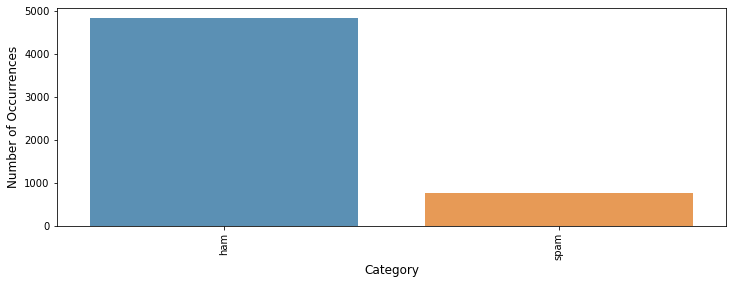

In [5]:
cnt_pro = df['Category'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(cnt_pro.index, cnt_pro.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Category', fontsize=12)
plt.xticks(rotation=90)
plt.show();

In [6]:
def print_message(index):
    example = df[df.index == index][['Message', 'Category']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Message:', example[1])
print_message(12)

URGENT! You have won a 1 week FREE membership in our Â£100,000 Prize Jackpot! Txt the word: CLAIM to No: 81010 T&C www.dbuk.net LCCLTD POBOX 4403LDNW1A7RW18

Message: spam


In [7]:
print_message(0)

Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...

Message: ham


Text Preprocessing Below we define a function to convert text to lower-case and strip punctuation/symbols from words and so on.

In [8]:
from bs4 import BeautifulSoup
def cleanText(text):
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'http\S+', r'<URL>', text)
    text = text.lower()
    text = text.replace('x', '')
    return text
df['Message'] = df['Message'].apply(cleanText)

In [9]:
df['Message'] = df['Message'].apply(cleanText)
train, test = train_test_split(df, test_size=0.000001 , random_state=42)
import nltk
from nltk.corpus import stopwords
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            #if len(word) < 0:
            if len(word) <= 0:
                continue
            tokens.append(word.lower())
    return tokens
train_tagged = train.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['Message']), tags=[r.Category]), axis=1)
test_tagged = test.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['Message']), tags=[r.Category]), axis=1)

# The maximum number of words to be used. (most frequent)
max_fatures = 500000

# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 50

#tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer = Tokenizer(num_words=max_fatures, split=' ', filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['Message'].values)
X = tokenizer.texts_to_sequences(df['Message'].values)
X = pad_sequences(X)
print('Found %s unique tokens.' % len(X))

Found 5572 unique tokens.


In [10]:
X = tokenizer.texts_to_sequences(df['Message'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (5572, 50)


In [11]:
#train_tagged.values[2173]
train_tagged.values

array([TaggedDocument(words=['and', 'also', 'i', "'ve", 'sorta', 'blown', 'him', 'off', 'a', 'couple', 'times', 'recently', 'so', 'id', 'rather', 'not', 'tet', 'him', 'out', 'of', 'the', 'blue', 'looking', 'for', 'weed'], tags=['ham']),
       TaggedDocument(words=['mmm', 'thats', 'better', 'now', 'i', 'got', 'a', 'roast', 'down', 'me', '!', 'iâ\x92d', 'b', 'better', 'if', 'i', 'had', 'a', 'few', 'drinks', 'down', 'me', '2', '!', 'good', 'indian', '?'], tags=['ham']),
       TaggedDocument(words=['mm', 'have', 'some', 'kanji', 'dont', 'eat', 'anything', 'heavy', 'ok'], tags=['ham']),
       ...,
       TaggedDocument(words=['prabha..i', "'m", 'soryda..realy..frm', 'heart', 'i', "'m", 'sory'], tags=['ham']),
       TaggedDocument(words=['nt', 'joking', 'seriously', 'i', 'told'], tags=['ham']),
       TaggedDocument(words=['did', 'he', 'just', 'say', 'somebody', 'is', 'named', 'tampa'], tags=['ham'])],
      dtype=object)

Model DM = 1

This work use DM=1 (it preserve word order)

In [12]:
d2v_model = Doc2Vec(dm=1, dm_mean=1, size=20, window=8, min_count=1, workers=1, alpha=0.065, min_alpha=0.065)
d2v_model.build_vocab([x for x in tqdm(train_tagged.values)])


/opt/conda/lib/python3.7/site-packages/gensim/models/doc2vec.py:319: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.

  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")

100%|██████████| 5571/5571 [00:00<00:00, 2063993.25it/s]


In [13]:
%%time
for epoch in range(30):
    d2v_model.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    d2v_model.alpha -= 0.002
    d2v_model.min_alpha = d2v_model.alpha

100%|██████████| 5571/5571 [00:00<00:00, 2317412.24it/s]

100%|██████████| 5571/5571 [00:00<00:00, 2210013.01it/s]

100%|██████████| 5571/5571 [00:00<00:00, 2024297.63it/s]

100%|██████████| 5571/5571 [00:00<00:00, 2213362.47it/s]

100%|██████████| 5571/5571 [00:00<00:00, 2325253.02it/s]

100%|██████████| 5571/5571 [00:00<00:00, 2216932.41it/s]

100%|██████████| 5571/5571 [00:00<00:00, 2223260.47it/s]

100%|██████████| 5571/5571 [00:00<00:00, 1617840.31it/s]

100%|██████████| 5571/5571 [00:00<00:00, 2130616.17it/s]

100%|██████████| 5571/5571 [00:00<00:00, 2248289.00it/s]

100%|██████████| 5571/5571 [00:00<00:00, 2134508.78it/s]

100%|██████████| 5571/5571 [00:00<00:00, 2324327.82it/s]

100%|██████████| 5571/5571 [00:00<00:00, 1783427.54it/s]

100%|██████████| 5571/5571 [00:00<00:00, 2083872.97it/s]

100%|██████████| 5571/5571 [00:00<00:00, 2168380.44it/s]

100%|██████████| 5571/5571 [00:00<00:00, 2232820.60it/s]

100%|██████████| 5571/5571 [00:00<00:00, 1247076.24it/s]

100%|█████████

CPU times: user 11.4 s, sys: 121 ms, total: 11.5 s

Wall time: 11.4 s


In [14]:
print(d2v_model)


Doc2Vec(dm/m,d20,n5,w8,s0.001)


In [15]:
len(d2v_model.wv.vocab)


9757

In [16]:
# save the vectors in a new matrix
embedding_matrix = np.zeros((len(d2v_model.wv.vocab)+ 1, 20))

for i, vec in enumerate(d2v_model.docvecs.vectors_docs):
    while i in vec <= 1000:
    #print(i)
    #print(model.docvecs)
          embedding_matrix[i]=vec
    #print(vec)
    #print(vec[i])

# Measuring distance between two vectors (related to cosine similarity)

In [17]:
d2v_model.wv.most_similar(positive=['urgent'], topn=10)


[('11mths+', 0.7566927671432495),
 ('received', 0.7357529401779175),
 ('ultimatum', 0.7274703979492188),
 ('brain', 0.724571704864502),
 ('haughaighgtujhyguj', 0.7183928489685059),
 ('been', 0.7129004597663879),
 ('denying', 0.7097295522689819),
 ('hahaha..use', 0.7089126110076904),
 ('bookedthe', 0.7022557258605957),
 ('lot..i', 0.7003313302993774)]

In [18]:
d2v_model.wv.most_similar(positive=['cherish'], topn=10)


[('intrepid', 0.8405887484550476),
 ('mojibiola', 0.7767326831817627),
 ('thank', 0.7729716897010803),
 ('knees', 0.725476086139679),
 ('enjoyed', 0.7111902236938477),
 ('dawns', 0.7011476755142212),
 ('pee', 0.6912188529968262),
 ('duo', 0.6908860206604004),
 ('hut', 0.6888827085494995),
 ('urgent', 0.6856852769851685)]

# Create the LSTM Model

The parameter used here inspired by [3].



In [19]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding


# init layer
model = Sequential()

# emmbed word vectors
model.add(Embedding(len(d2v_model.wv.vocab)+1,20,input_length=X.shape[1],weights=[embedding_matrix],trainable=True))

# learn the correlations
def split_input(sequence):
     return sequence[:-1], tf.reshape(sequence[1:], (-1,1))
model.add(LSTM(50,return_sequences=False))
model.add(Dense(2,activation="softmax"))

# output model skeleton
model.summary()
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=['acc'])

Model: "sequential"

_________________________________________________________________

Layer (type)                 Output Shape              Param #   


embedding (Embedding)        (None, 50, 20)            195160    

_________________________________________________________________

lstm (LSTM)                  (None, 50)                14200     

_________________________________________________________________

dense (Dense)                (None, 2)                 102       


Total params: 209,462

Trainable params: 209,462

Non-trainable params: 0

_________________________________________________________________


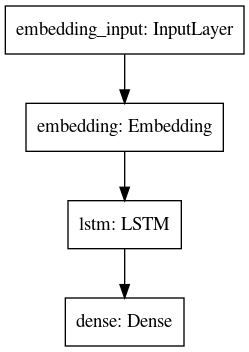

In [20]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

In [21]:
Y = pd.get_dummies(df['Category']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.15, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(4736, 50) (4736, 2)

(836, 50) (836, 2)


In [22]:
batch_size = 32
history=model.fit(X_train, Y_train, epochs =50, batch_size=batch_size, verbose = 2)

Epoch 1/50

148/148 - 2s - loss: 0.2365 - acc: 0.9191

Epoch 2/50

148/148 - 2s - loss: 0.0401 - acc: 0.9901

Epoch 3/50

148/148 - 3s - loss: 0.0157 - acc: 0.9962

Epoch 4/50

148/148 - 3s - loss: 0.0087 - acc: 0.9973

Epoch 5/50

148/148 - 3s - loss: 0.0036 - acc: 0.9992

Epoch 6/50

148/148 - 3s - loss: 0.0015 - acc: 0.9996

Epoch 7/50

148/148 - 3s - loss: 0.0023 - acc: 0.9994

Epoch 8/50

148/148 - 3s - loss: 0.0011 - acc: 0.9998

Epoch 9/50

148/148 - 3s - loss: 6.2552e-04 - acc: 1.0000

Epoch 10/50

148/148 - 3s - loss: 4.2979e-04 - acc: 1.0000

Epoch 11/50

148/148 - 3s - loss: 2.8563e-04 - acc: 1.0000

Epoch 12/50

148/148 - 3s - loss: 3.0239e-04 - acc: 1.0000

Epoch 13/50

148/148 - 3s - loss: 2.1977e-04 - acc: 1.0000

Epoch 14/50

148/148 - 2s - loss: 1.9864e-04 - acc: 1.0000

Epoch 15/50

148/148 - 2s - loss: 1.6579e-04 - acc: 1.0000

Epoch 16/50

148/148 - 3s - loss: 1.3074e-04 - acc: 1.0000

Epoch 17/50

148/148 - 3s - loss: 9.8520e-05 - acc: 1.0000

Epoch 18/50

148/148 

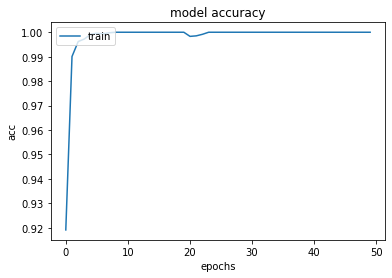

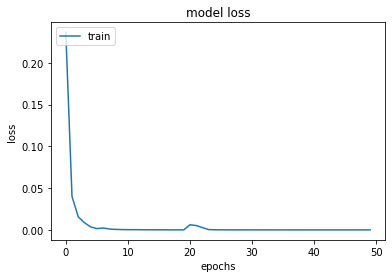

<Figure size 432x288 with 0 Axes>

In [23]:
plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('model_accuracy.png')

# summarize history for loss
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('model_loss.png')

In [24]:
# evaluate the model
_, train_acc = model.evaluate(X_train, Y_train, verbose=2)
_, test_acc = model.evaluate(X_test, Y_test, verbose=2)
print('Train: %.3f, Test: %.4f' % (train_acc, test_acc))

148/148 - 1s - loss: 4.2103e-06 - acc: 1.0000

27/27 - 0s - loss: 0.0973 - acc: 0.9880

Train: 1.000, Test: 0.9880


In [25]:
# predict probabilities for test set
yhat_probs = model.predict(X_test, verbose=0)
print(yhat_probs)
# predict crisp classes for test set
yhat_classes = model.predict_classes(X_test, verbose=0)
print(yhat_classes)
# reduce to 1d array
yhat_probs = yhat_probs[:, 0]
#yhat_classes = yhat_classes[:, 1

[[9.9999976e-01 1.8440993e-07]

 [9.9999869e-01 1.3441303e-06]

 [9.9999928e-01 7.6641811e-07]

 ...

 [9.9999964e-01 3.9340065e-07]

 [9.9999988e-01 8.5513342e-08]

 [9.9999809e-01 1.9259865e-06]]

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0

 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 1 1

 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0

 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1

 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0

 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0

 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0

 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0

 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

In [26]:
import numpy as np
rounded_labels=np.argmax(Y_test, axis=1)
rounded_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0,

In [27]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(rounded_labels, yhat_classes)
cm

array([[727,   2],
       [  8,  99]])

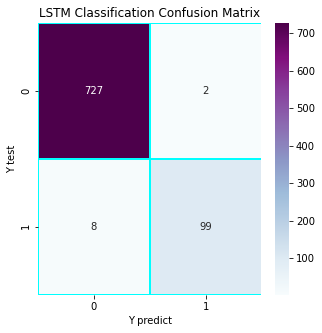

In [28]:
# The confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

lstm_val = confusion_matrix(rounded_labels, yhat_classes)
f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(lstm_val, annot=True, linewidth=0.7, linecolor='cyan', fmt='g', ax=ax, cmap="BuPu")
plt.title('LSTM Classification Confusion Matrix')
plt.xlabel('Y predict')
plt.ylabel('Y test')
plt.show()

In [29]:
validation_size = 200

X_validate = X_test[-validation_size:]
Y_validate = Y_test[-validation_size:]
X_test = X_test[:-validation_size]
Y_test = Y_test[:-validation_size]
score,acc = model.evaluate(X_test, Y_test, verbose = 1, batch_size = batch_size)

print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

20/20 [==============================] - 0s 6ms/step - loss: 0.1248 - acc: 0.9858

score: 0.12

acc: 0.99


**Save Model**


In [30]:

model.save('Mymodel.h5')

**Test with new and different data set aside from the data to build the model.**

In [31]:
message = ['Congratulations! you have won a $1,000 Walmart gift card. Go to http://bit.ly/123456 to claim now.']
seq = tokenizer.texts_to_sequences(message)

padded = pad_sequences(seq, maxlen=X.shape[1], dtype='int32', value=0)

pred = model.predict(padded)

labels = ['ham','spam']
print(pred, labels[np.argmax(pred)])

[[0.10068891 0.89931107]] spam


In [32]:
message = ['thanks for accepting my request to connect']
seq = tokenizer.texts_to_sequences(message)

padded = pad_sequences(seq, maxlen=X.shape[1], dtype='int32', value=0)

pred = model.predict(padded)

labels = ['ham','spam']
print(pred, labels[np.argmax(pred)])

[[9.999981e-01 1.965969e-06]] ham
